Loaded 503 tickers, e.g. ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN']
After cleaning, 439 tickers remain.


/var/folders/yf/l3m9d7xd3lg3_lv2zrkyg42r0000gn/T/ipykernel_12605/3591073314.py:49: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  439 of 439 completed
/var/folders/yf/l3m9d7xd3lg3_lv2zrkyg42r0000gn/T/ipykernel_12605/3591073314.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = adj_close.resample("M").last() #picks the last trading day of each month (one price per month per stock)


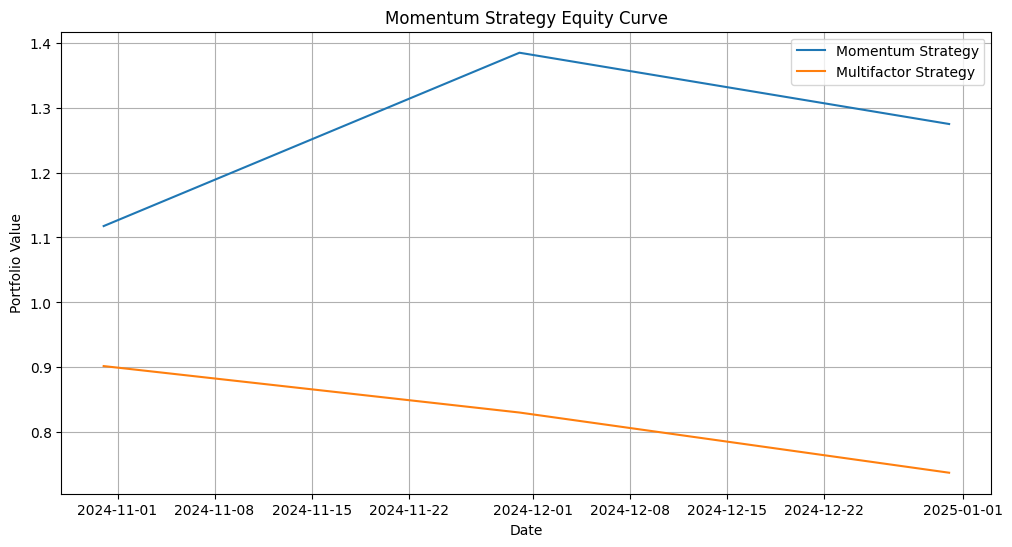

Momentum Only        | CAGR: 327.56% | Sharpe:  1.99 | MaxDD: -7.93%
Multi-Factor LS      | CAGR: -83.82% | Sharpe: -20.55 | MaxDD: -18.22%


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cost_per_trade = 0.0005   # 5 basis points per stock traded
wiki_url   = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_data = pd.read_html(wiki_url, header=0)[0]
tickers = (
     sp500_data.Symbol.str.replace(r"\.", "-", regex = True).tolist()
)
print(f"Loaded {len(tickers)} tickers, e.g. {tickers[:5]}")
# To see the value of the tickers, we will look at the Price-to-Earning (P/E) ratio and ROE (Return on Equity) of each stock
#P/E = Price per Share / Earnings per Share (EPS) → How much are you paying for each dollar of earnings?
#ROE = Net Income / Shareholder's Equity → How efficiently is a company using its equity to generate profits?
pe_dict = {}
roe_dict = {}
for t in tickers:
    info = yf.Ticker(t).info
    pe_dict[t] = info.get("trailingPE", None)
    roe_dict[t] = info.get("returnOnEquity", None)

funds = pd.DataFrame({
    "PE": pe_dict,
    "ROE": roe_dict
})
funds["Value"] = 1/ funds["PE"] #Lower P/E means better value, so we take the inverse to get a "Value" score
funds["Quality"] = funds["ROE"] #Higher ROE means better quality, so we use ROE directly as a "Quality" score

# ────────────────────────────────────────────────────
# Cleanup: drop tickers without valid Value or Quality
# ────────────────────────────────────────────────────

# Replace any infinities from 1/PE with NaN
funds.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop tickers missing either Value or Quality
funds.dropna(subset=["Value", "Quality"], inplace=True)

# Sync your ticker list so loops only include these
clean_tickers = [t for t in tickers if t in funds.index]
print(f"After cleaning, {len(clean_tickers)} tickers remain.")

# Then overwrite for everything that follows:
tickers = clean_tickers

# Download daily adjusted closing prices
data = yf.download(
    tickers,
    start="2015-01-01",
    end="2024-12-31"
    # auto_adjust=True by default
)
adj_close = data["Close"] #grabbing the adjusted close prices of each ticket

# Resample to monthly data
monthly_prices = adj_close.resample("M").last() #picks the last trading day of each month (one price per month per stock)

# Calculate 6-month momentum
momentum = monthly_prices.pct_change(periods=6).dropna() #Percentage change over the last 6 months, (price now - price 6 months ago) / price 6 months ago
#dropna() removes 6 months of NaN values since we can't calculate momentum for the first 6 months
# Calculate next month returns
returns = monthly_prices.pct_change().dropna() #Percentage change over the last month

# Simulate strategy: long top 2 momentum stocks monthly
portfolio_returns = []

def zscore(series):
        return (series - series.mean()) / series.std()

for date in momentum.index[:-1]:
    top_stocks = momentum.loc[date].nlargest(2).index
    next_month = returns.index[returns.index.get_loc(date) + 1]
    next_returns = returns.loc[next_month, top_stocks]
    
    gross_ret = next_returns.mean()
    turnover  = len(top_stocks)
    net_ret   = gross_ret - cost_per_trade * turnover

    portfolio_returns.append((next_month, net_ret))


# Convert to DataFrame, or table
portfolio_df = pd.DataFrame(portfolio_returns, columns=["Date", "Return"])
portfolio_df.set_index("Date", inplace=True) #table with monthly portfolio returns
portfolio_df["Cumulative"] = (1 + portfolio_df["Return"]).cumprod() #Calculutes cumulative returns starting from 1 dollar

mf_returns = []
for date in momentum.index[:-1]:
     mom_z = zscore(momentum.loc[date])
     val_z = zscore(funds["Value"])
     qual_z = zscore(funds["Quality"])
     comp = 0.4 * mom_z + 0.3 * val_z + 0.3 * qual_z
     
     longs  = comp.nlargest(n).index
     shorts = comp.nsmallest(n).index
     
     nxt     = returns.index[returns.index.get_loc(date) + 1]
     r_long  = returns.loc[nxt, longs].mean()
     r_short = returns.loc[nxt, shorts].mean()
     
     gross_mf = r_long - r_short
     turnover = len(longs) + len(shorts)
     net_mf   = gross_mf - cost_per_trade * turnover
     
     mf_returns.append((nxt, net_mf))

mf_df = pd.DataFrame(mf_returns, columns=["Date", "Return"]).set_index("Date") #table with monthly returns of the multifactor strategy
mf_df["Cumulative"] = (1 + mf_df["Return"]).cumprod() #Calculates cumulative returns starting from 1 dollar

# Plot equity curve
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df["Cumulative"], label="Momentum Strategy")
plt.plot(mf_df["Cumulative"], label="Multifactor Strategy")
plt.title("Momentum Strategy Equity Curve")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()

def print_metrics(df, name):
    """
    Prints CAGR, Sharpe Ratio, and Max Drawdown for a backtest DataFrame.
    Assumes df.index is datetime, df['Return'] is periodic returns,
    and df['Cumulative'] is cumulative growth starting from 1.
    """
    # Total years in the backtest
    years = (df.index[-1] - df.index[0]).days / 365
    
    # Ending value of $1
    ending_value = df["Cumulative"].iloc[-1]
    
    # CAGR
    cagr = ending_value ** (1 / years) - 1
    
    # Monthly mean & std dev
    mean_ret = df["Return"].mean()
    std_ret  = df["Return"].std()
    
    # Annualized Sharpe (zero risk-free)
    sharpe = (mean_ret / std_ret) * np.sqrt(12)
    
    # Max Drawdown
    dd = (df["Cumulative"] / df["Cumulative"].cummax() - 1).min()
    
    print(f"{name:20s} | CAGR: {cagr:6.2%} | Sharpe: {sharpe:5.2f} | MaxDD: {dd:6.2%}")

# ───────────────────────────────────────────────
# Now call it for both strategies:
print_metrics(portfolio_df, "Momentum Only")
print_metrics(mf_df,       "Multi-Factor LS")
